In [1]:
import os
import numpy as np
import glob
import pandas as pd
import geopandas as gpd
import matplotlib.pyplot as plt
import shapely
import shapely.geometry
from descartes import PolygonPatch
import matplotlib
from matplotlib.colors import LinearSegmentedColormap

from maskrcnn.postprocess.analysis import load_gd_census, snap_to_grid


matplotlib.rc('pdf', fonttype=42)

In [2]:
def plot(raster, file,
         cmap, vmin, vmax,
         bound,
         min_lon, max_lon, min_lat, max_lat, step):
    outside = shapely.geometry.box(min_lon, min_lat, max_lon, max_lat).difference(bound)
    fig, ax = plt.subplots(figsize=(16, 12))
    im = ax.imshow(raster,
                   extent=(min_lon, max_lon, min_lat, max_lat),
                   cmap=cmap, vmin=vmin, vmax=vmax)
    ax.plot(*bound.exterior.xy, color='white', linewidth=5)
    ax.add_patch(PolygonPatch(outside, facecolor='#dddddd', edgecolor='#dddddd'))
    ax.axis('off')
    ax.set_aspect(1)
    fig.colorbar(im)
    fig.savefig(file)

In [3]:
# SET-UP

IN_BOUND_DIR = 'data/External/GiveDirectly/figure2/SampleArea.shp'
IN_CENSUS_GPS_DIR = 'data/External/GiveDirectly/GE_HH_Census_2017-07-17_cleanGPS.csv'
IN_CENSUS_MASTER_DIR = 'data/External/GiveDirectly/GE_HH-Census_Analysis_RA_2017-07-17.dta'
IN_SAT_DIR = 'data/Siaya/Merged/sat.csv'

OUT_DIR = 'output/fig-map'

# define the grid
grid = {
    'min_lon': 34.03,  # 34.067830
    'max_lon': 34.46,  # 34.450290
    'min_lat': -0.06,  # -0.048042
    'max_lat': 0.32,  # 0.317786
    'step': 0.002,  # degrees
}

palette = ['#d7191c', '#fdae61', '#ffffbf', '#abd9e9', '#2c7bb6']

# load sample area geometry
bound, = gpd.read_file(IN_BOUND_DIR)['geometry']

In [4]:
# PLOT TREATMENT
# load the data frame for treatment status
df_treat = load_gd_census(
    GPS_FILE=IN_CENSUS_GPS_DIR, MASTER_FILE=IN_CENSUS_MASTER_DIR)
# snap to grid
(grid_lon, grid_lat), df_raster = snap_to_grid(
    df_treat, lon_col='longitude', lat_col='latitude', **grid,
    n_household=pd.NamedAgg(column='treat_eligible', aggfunc='count'),
    eligible=pd.NamedAgg(column='eligible', aggfunc='sum'),
    treat_eligible=pd.NamedAgg(column='treat_eligible', aggfunc='sum'),
)
df_raster.fillna(0, inplace=True)
# construct pct of eligible households treated
df_raster.loc[:, 'treat_pct'] = df_raster.apply(
    lambda x: np.nan if x['eligible'] == 0 else (x['treat_eligible'] / x['eligible']),
    axis=1)

# convert to raster
raster = df_raster['treat_pct'].values.reshape(grid_lon.shape)[::-1, :]

Dropping 0 observations;
Keeping 40850 observations


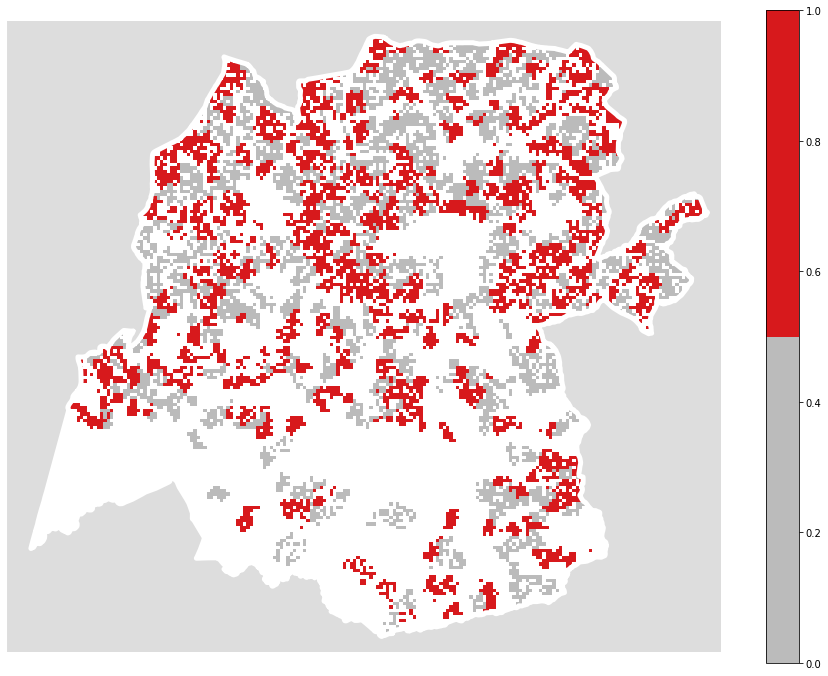

In [5]:
# plotting begins
cmap = LinearSegmentedColormap.from_list(
    '', [(0, '#bbbbbb'), (1, palette[0])], N=2)
cmap.set_bad('#ffffff')
plot(
    raster=raster,
    file=os.path.join(OUT_DIR, 'treat_pct.pdf'),
    cmap=cmap, vmin=0, vmax=1,
    bound=bound, **grid)

Dropping 3699 observations;
Keeping 40850 observations


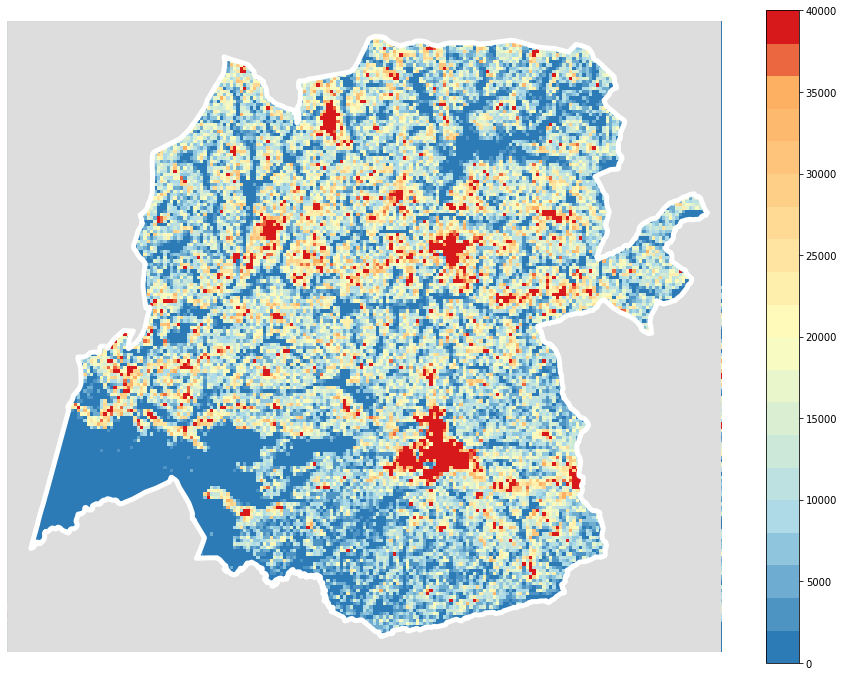

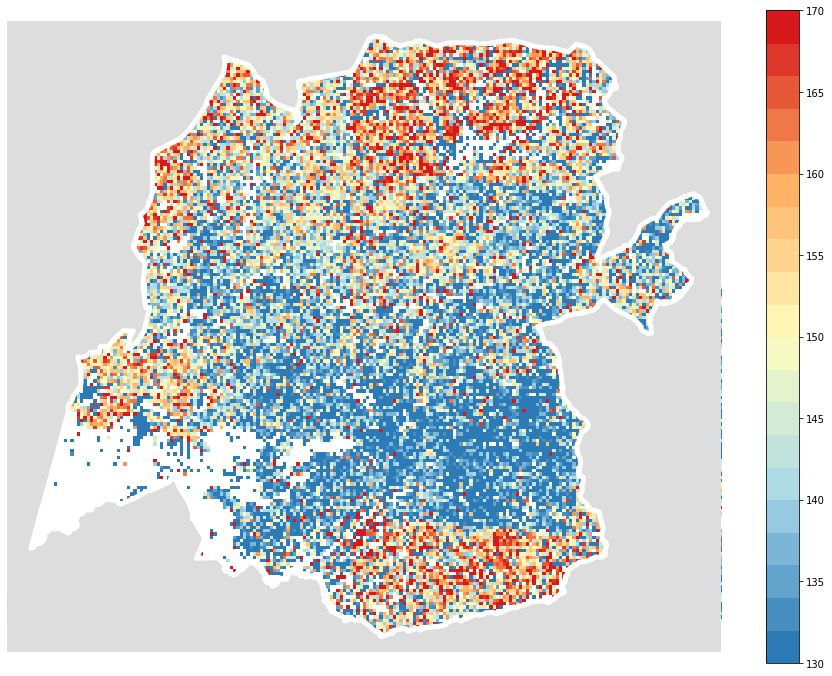

In [6]:
# PLOT OUTCOMES

# load satellite predictions
df_sat = pd.read_csv(IN_SAT_DIR)
# create new var
df_sat.loc[:, 'RGB_mean'] = df_sat.loc[:, ['R_mean', 'G_mean', 'B_mean']].mean(axis=1)
# snap to grid
(grid_lon, grid_lat), df_raster = snap_to_grid(
    df_sat, lon_col='centroid_lon', lat_col='centroid_lat', **grid,
    house_count=pd.NamedAgg(column='area', aggfunc='count'),
    area_sum=pd.NamedAgg(column='area', aggfunc='sum'),
    RGB_mean=pd.NamedAgg(column='RGB_mean', aggfunc='mean'),
)
df_raster = df_raster.fillna({'house_count': 0, 'area_sum': 0})

# plotting begins
for outcome, vmin, vmax, cmap_break in zip(
    ['area_sum', 'RGB_mean'],  # outcome
    [0, 130],  # vmin
    [4e4, 170],  # vmax
    [[0, .2, .5, .9, 1], [0, .25, .5, .75, 1]],  # cmap_break
):
    cmap = LinearSegmentedColormap.from_list(
        '', list(zip(cmap_break, palette[::-1])), N=20)
    cmap.set_bad('#ffffff')
    raster = df_raster[outcome].values.reshape(grid_lon.shape)[::-1, :]
    plot(
        raster=raster,
        file=os.path.join(OUT_DIR, outcome + '.pdf'),
        cmap=cmap, vmin=vmin, vmax=vmax,
        bound=bound, **grid)